![Project Logo](Project_Logo.pdf)

## PyUltraLight NBody

# Build 0.25 Advanced (25 Nov 2020)



* Y. Wang: [yourong.f.wang@auckland.ac.nz]

* J. Zagorac
* R. Easther
* N. Guo



### Integrator:
#### Designed for PyULN7

### Auxilliary Script:
#### Requires ULHelper 5 or later.






In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Loading Required Packages

In [4]:
import PyUltraLight_NBody_8_Superfast as PyUL
print('PyUltralight: Integrator Date', PyUL.D_version)

import PyUL_Helper as PyULH

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec
import matplotlib.animation
import math

import pyfftw
import os
import sys
import multiprocessing
import numpy
import numba
import h5py
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from IPython.core.display import clear_output, display

Colors = np.array([[209,17,65],[0,177,89],[0,174,219],[243,119,53],[255,196,37]])/255

Palette = 'ocean'

import numexpr as ne
import matplotlib as mpl
mpl.style.use('seaborn')

PyUltralight: Integrator Date 2020 11 26. NBody Completion


# Disk Space Management:

In [5]:
save_path = 'ULDScience'  # Set output directory

PyULH.DSManagement(save_path)

ULDScience : The current size of the folder is 251.463 Mib
ULDScience : Do You Wish to Delete All Files Currently Stored In This Folder? [Y] 

Y
Folder Cleaned! 

ULDScience : Save Folder Created.


# Begin NEW RUN 

# ULDM Simulation Parameters

In [14]:
##================================================================
## Important Ones

# Space Settings
resol = 128
length = 8 # 1 code unit is ~38 kpc x (1e-22/m_a)^0.5
length_units = ''  # Accepted units: 'm', 'km', 'pc', 'kpc', 'Mpc', 'ly', and '' for dimensionless units.

# Time Settings
duration = 1.5 #1 code unit is ~70 Gyr (independent of axion mass assumption)
duration_units = ''  # Accepted units: 's', 'yr', 'kyr', 'Myr', and '' for dimensionless units
start_time = 0. # Should be given in the same units as duration. 
step_factor = 1 # Change this to a larger number if velocities are sufficiently low that constraint on timestep can be relaxed. 

# Snapshot Settings A
save_number = 160
# Recommended Save Number Cap: 60
# Depending on resolution, this could require significant disk space.

# Runge-Kutta Steps for NBody
NS = 4 # 1,4,8,16,... NBody Integration Steps per ULD Step.

##================================================================
## Other Flags
# Set units for soliton parameters
s_mass_unit = ''     #Accepted units: 'kg', 'solar_masses', 'M_solar_masses', and '' for dimensionless units
s_position_unit = '' #Accepted units: 'm', 'km', 'pc', 'kpc', 'Mpc', 'ly', and '' for dimensionless units
s_velocity_unit = '' #Accepted units: 'm/s', 'km/s', 'km/h', and '' for dimensionless units

# Rules ditto.
m_mass_unit = ''
m_position_unit = ''
m_velocity_unit = ''

# Density, if Uniform Background Flag is Set to 'True'
# 1 Code Density Unit is equal the universe's critical matter density, 2.67e-27 kg/m^3.
density_unit = '' # Accepted units: 'MSol/pc3', 'kg/m3', and '' for dimensionless units



##================================================================
## Multithreading, IO, and Control
num_threads = multiprocessing.cpu_count()
print("Available CPU threads for this run: ",num_threads)
print(f"Simulating a {length} ({length_units}) box at resolution: {resol} cubed.")

LengthFS = PyUL.convert(length, length_units, 'l')

GridLenFS = LengthFS/(resol)

GridLenPC = PyUL.convert_back(GridLenFS,'pc','l')

print(f"The grid subdivision is {length/resol:.4f} in specified units. This is {GridLenFS:.4f} code units.")

#Formats to save
hdf5 = False
npz = False
npy = True

#Data to save
#0
save_rho = False # Saves density data for entire 3D simulation grid
#1
save_psi = False # Saves ULD Phase Data in plane
#2
save_plane = True # Saves density data for plane z = 0
#3
save_energies = True # Saves integrated gravitational, kinetic and total energies as lists
#4
save_line = False # Saves density data for line y = 0, z = 0. Useful for examining intereference patterns. 
#5
save_testmass = True # Saves trajectory and 3-velocity of a test mass thrown into the system.   
#6
save_phi = False
#7
save_phi_plane = True
#8
save_gradients = True
#9
save_phase_plane = True

save_options = [save_rho,save_psi,save_plane,save_energies,save_line,save_testmass,save_phi,save_phi_plane,save_gradients,save_phase_plane]

SaveSizeEstimate = PyULH.SSEst(save_options,save_number,resol)

print('Estimated Save Size (GiB): %.02f' % SaveSizeEstimate )

central_mass = 0 # Not Implemented Anymore. Keep for code compatibility.

Available CPU threads for this run:  16
Simulating a 8 () box at resolution: 128 cubed.
The grid subdivision is 0.0625 in specified units. This is 0.0625 code units.
ULHelper: Saving Mass Density Data (2D)
ULHelper: Saving ULD Argument Data (2D)
ULHelper: Saving Gravitational Field Data (2D)
ULHelper: Saving NBody Gradient Data
ULHelper: Saving NBody Position Data
Estimated Save Size (GiB): 0.06


# Gravitational Field Smoothing
Instead of coding in the idealistic $\frac{m}{r}$ potential, we approximate it with $\frac{am}{ar+e^{-ar}}$. 

The modified potential is a useful approximation of a point mass in a distance, and puts an exponential cap on the infinite potential well, which reduces the impact of numerical artefacts.


The smoothing factor, $a$, is also defined here.


The differences between the two potentials are characterised in the following box.

The Smoothing factor is 34.538


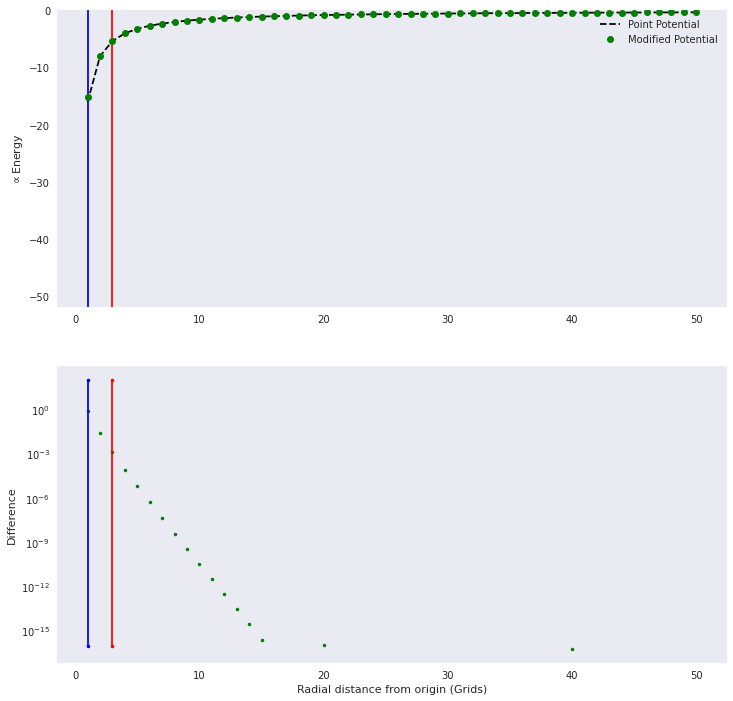

Generating Field Smoothing Report:
  The simulation runs on a 128^3 grid with total side length 8.0
  The simulation grid size is 0.0625 Code Units,
  

==========Grid Counts of Important Features=========

  Radius outside which the fields are practically indistinguishable (Grids): 3
  Modified Potential HWHM (Grids): 1


In [15]:
a = (2-PyUL.LW(np.exp(-2)))/LengthFS*resol

print(f"The Smoothing factor is {a:.3f}")

PyULH.SmoothingReport(a,resol,LengthFS)

# Custom Initial Conditions

In [16]:
BH1 = [5,[1.3,0,0],[-0.2,-1.1,0]]

BH2 = [4,[-1,-0.5,0],[0,0.1,0]]

BH3 = [3,[2.5,0,0],[0,2.2,0]]

Observer1 = [0,[3,3,0],[0,0,0]]

Observer2 = [0,[0,-3,0],[0,0,0]]

particles = [BH1,BH2,BH3]


soliton1 = [9, [1,2,0], [-2,-1,0], 0]

soliton2 = [10, [-3,-2,0], [1,2,0], 0]

solitons = []

########### MODIFIER PARAMETERS

# Removes all ULDM Structures defined elsewhere in the IV and replaces them with a uniform wavefunction 
# with given probability amplitude (code unit).

Uniform = True
Density = 4
#Density = 0


Avg = False # Whether we average the black hole local field evaluation. 
#False: Only evaluate Locally. 
#True: 6 Nearby Evaluators.

AvgDist = 1.42 # How far away the antennae are compared to grid length.
CentreWeight = 1 # The relative weight of central point to the antennae.

NCV, NCW = PyULH.PInit(Avg,AvgDist,CentreWeight)  

if not Uniform:
    print('The List of Soliton Conditions is:')
    print(solitons)
    
print('The List of BH Conditions is:')  
print(particles)

The List of BH Conditions is:
[[5, [1.3, 0, 0], [-0.2, -1.1, 0]], [4, [-1, -0.5, 0], [0, 0.1, 0]], [3, [2.5, 0, 0], [0, 2.2, 0]]]


# The New Elliptical Orbit

Thanks Canada.

In [ ]:
HaloMass1 = 0.1 # User Input

HaloMass2 = 0.1# User Input

Aphelion = 0.6 # User Input

e = 0.13 # Eccentricity. 0 -> Circle. 1 -> Parabola. 

Ratio = 1 # How much of the calculated mass is BH.

BHMass1 = HaloMass1*Ratio
BHMass2 = HaloMass2*Ratio

# Converting to SI Units.
m1 = HaloMass1 + BHMass1
m2 = HaloMass2 + BHMass2

M = m1 + m2
xC = Aphelion

## Simulation always starts from Aphelion, in Centre-of-mass Frame

x2 = xC * m1/M # Bigger Mass, Smaller Initial Position
x1 = xC - x2

a1 = x1 / (1+e) # Semimajor Axis from Aphelion
a2 = x2 / (1+e)

xPeri1 = a1*(1-e)
xPeri2 = a2*(1-e)

print(xPeri1 + xPeri2)
## Initial Velocity is purely tangential.


# Actual Orbit

yDot1 = np.sqrt(m2*x1/xC**2*(1-e)/(1+e))
yDot2 = np.sqrt(m1*x2/xC**2*(1-e)/(1+e))

Object1 = [BHMass1, [x1,0,0], [0,yDot1,0]]
Object2 = [BHMass2, [-x2,0,0], [0,-yDot2,0]]

particles = [Object1,Object2]

Halo1 = [HaloMass1, [x1,0,0], [0,yDot1,0],0]
Halo2 = [HaloMass2, [-x2,0,0], [0,-yDot2,0],np.pi]

solitons = [Halo1,Halo2]

########### MODIFIER PARAMETERS
# Removes all ULDM Structures defined elsewhere in the IV and replaces them with a uniform wavefunction 
# with given probability amplitude (code unit).

Uniform = True
Density = 0.001


Avg = False # Whether we average the black hole local field evaluation. 
#False: Only evaluate Locally. 
#True: 6 Nearby Evaluators.

AvgDist = 1.42 # How far away the antennae are compared to grid length.
CentreWeight = 1 # The relative weight of central point to the antennae.

NCV, NCW = PyULH.PInit(Avg,AvgDist,CentreWeight)  

if not Uniform:
    print('The List of Soliton Conditions is:')
    print(solitons)
    
print('The List of BH Conditions is:')  
print(particles)

# The New Scattering

In [ ]:
AllULD = False

HaloMass1 = 8 # User Input

HaloMass2 = 6 # User Input

Ratio = 0.01 # How much of the calculated mass is BH.

BHMass1 = HaloMass1*Ratio
BHMass2 = HaloMass2*Ratio

Phase = 0 # Multiples of pi, Applied Both Halos symmetrically.

b = 0.7 # Impact Parameter

vRel0 = 3 # Initial Speed along Collision Axis

Separation = 3

# Converting.
m1 = HaloMass1 + BHMass1
m2 = HaloMass2 + BHMass2

# Unit 2
y2 = Separation*m1/(m1+m2)
x2 = b*m1/(m1+m2)
yDot2 = vRel0*m1/(m1+m2)

# Unit 1
y1 = Separation*m2/(m1+m2)
x1 = b*m2/(m1+m2)
yDot1 = vRel0*m2/(m1+m2)


if AllULD:
    particles = []
    
    Halo1 = [m1, [x1,y1,0], [0,-yDot1,0],Phase*np.pi/2]
    Halo2 = [m2, [-x2,-y2,0], [0,yDot2,0],-1*Phase*np.pi/2]
    solitons = [Halo1,Halo2]
    
else:
    Object1 = [BHMass1,[x1,y1,0],[0,-yDot1,0]]
    Object2 = [BHMass2,[-x2,-y2,0],[0,yDot2,0]]
    particles = [Object1, Object2]


    Halo1 = [HaloMass1, [x1,y1,0], [0,-yDot1,0],Phase*np.pi/2]
    Halo2 = [HaloMass2, [-x2,-y2,0], [0,yDot2,0],-1*Phase*np.pi/2]
    solitons = [Halo1,Halo2]


Uniform = False
Density = 0.0095


Avg = False # Whether we average the black hole local field evaluation. 
#False: Only evaluate Locally. 
#True: 6 Nearby Evaluators.

AvgDist = 1.42 # How far away the antennae are compared to grid length.
CentreWeight = 1 # The relative weight of central point to the antennae.

NCV, NCW = PyULH.PInit(Avg,AvgDist,CentreWeight)  

if not Uniform:
    print('The List of Soliton Conditions is:')
    print(solitons)
    
print('The List of BH Conditions is:')  
print(particles)

# Compiling and Go

This creates a timestamped folder using the current settings, and the integrator stores all requested files in it too.

In [20]:
run_folder = PyULH.GenerateConfig(NS, central_mass, length, length_units, resol, duration, duration_units, step_factor, save_number, save_options, save_path, npz, npy, hdf5, s_mass_unit, s_position_unit, s_velocity_unit, solitons,start_time, m_mass_unit, m_position_unit, m_velocity_unit, particles, Uniform,Density,density_unit,a, NCV,NCW)

loc = './' + save_path + '/' + run_folder
print('Compiled Config in Folder', run_folder)

Method = 1

NS = 4
# 1: Real Space Linear Interpolation. 2: Fourier Sum (DEP'D.)

try:
    PyUL.evolve(save_path,run_folder,Method) 

except KeyboardInterrupt:
    print("\n Run Interrupted! The ability to resume simulations is under development.")

What is the name of the run? Leave blank to use automatically generated timestamp.

Compiled Config in Folder 20201126_162701@128
PyULN8 IO: Loaded Configuration In ./ULDScience/20201126_162701@128
PyULN8 Runtime: Using Linear Interpolation For Gravity.
PyULN8 Init: Simulating 0 ULDM solitons and 3 partcles.
PyULN8 Init: The point mass smoothing factor is 34.53751.
PyULN8 IO: Simulation Started at 26/11/2020, 16:27:01.

PyULN8 Load Soliton: Loaded original PyUL soliton profiles.
PyULN8 Init: Solitons overridden with a uniform wavefunction with no phase.
PyULN8 Init: Initial density is 0.00098 per mesh grid.
PyULN8 Init: Poisson Equation Solveed Using FFT.
PyULN8 Init: Particle #0 loaded, with (code) mass 5.000
PyULN8 Init: Particle #1 loaded, with (code) mass 4.000
PyULN8 Init: Particle #2 loaded, with (code) mass 3.000
PyULN8 Init: The initial NBody state vector is:
[[ 1.3  0.   0.  -0.2 -1.1  0. ]
 [-1.  -0.5  0.   0.   0.1  0. ]
 [ 2.5  0.   0.   0.   2.2  0. ]]
PyULN8 Runtime: The 

# Data (Re)Loading:

This block loads all data produced into memory. You can specify which folder to load by uncommenting the third line.

In [24]:
TimeStamp = PyULH.Runs(save_path)

#TimeStamp = PyULH.Load_Latest(save_path)

# Uncomment to Load Custom Configs

# TimeStamp = 'S256'

loc = './' + save_path + '/' + TimeStamp
NS, central_mass, length, length_units, resol, duration, duration_units, step_factor, save_number, save_options, save_path, npz, npy, hdf5, s_mass_unit, s_position_unit, s_velocity_unit, solitons,start_time, m_mass_unit, m_position_unit, m_velocity_unit, particles, Uniform,Density, density_unit ,a, NCV,NCW = PyUL.LoadConfig(loc)

EndNum, data, TMdata, phidata, graddata, phasedata = PyULH.Load_Data(save_path,TimeStamp, save_options,save_number)

LengthFS = PyUL.convert(length, length_units, 'l')

GridLenFS = LengthFS/(resol)

GridLenPC = PyUL.convert_back(GridLenFS,'pc','l')



[ 1 ]:  2020.11.26_16_22_13_128
[ 2 ]:  20201126_162701@128
Which folder do you want to analyse? Blank to load the latest one.
1
ULHelper: You chose to load 2020.11.26_16_22_13_128
ULHelper: Loaded Planar Mass Density Data 

ULHelper: Loaded Test Mass State Data 

ULHelper: Loaded Planar Gravitational Field Data 

ULHelper: Loaded Test Mass Gradient Data 

ULHelper: Loaded Planar ULD Phase Data 

ULHelper: Loaded 161 Data Entries


# 2D Trajectory Plot

<Figure size 576x396 with 0 Axes>

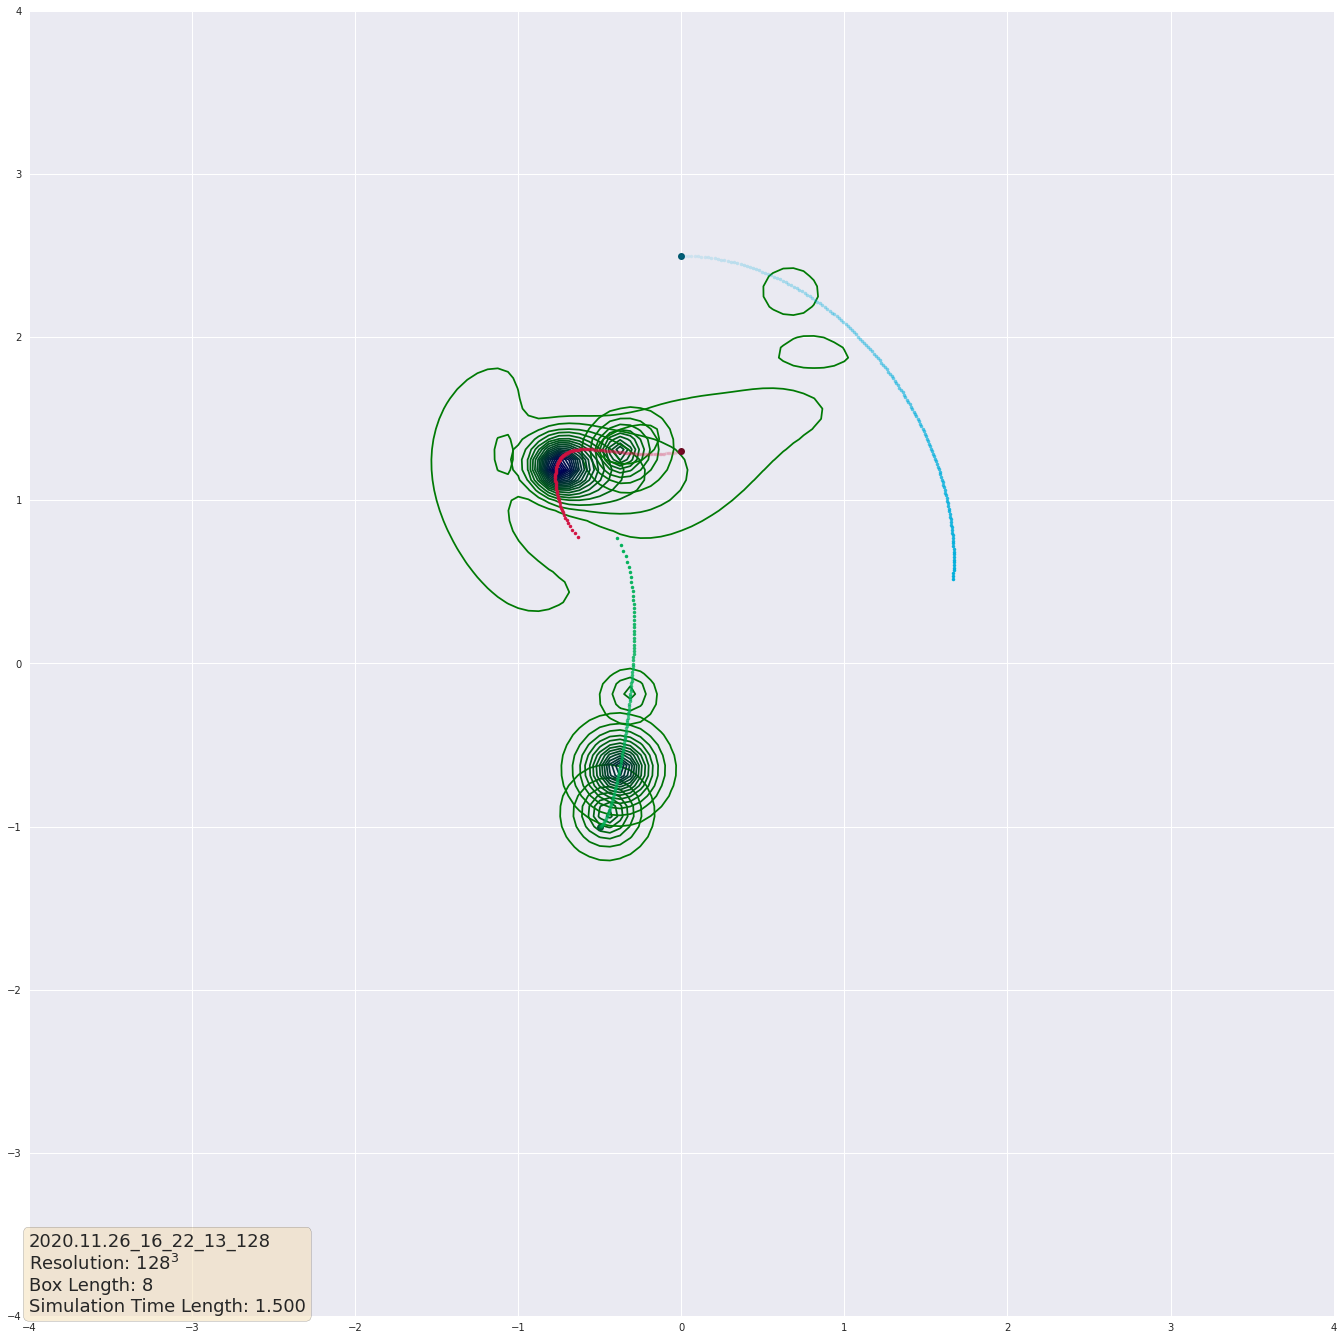

2020.11.26_16_22_13_128


In [25]:
# Number of ULDM Slices
NSlices = 4

try:
    TSD = TimeStamp
except NameError:
    TimeStamp = 'Debug'

plt.clf()

fig = plt.figure(figsize=(24, 24))
ax = fig.add_subplot(111)

Zoom2D = 1

Boundary = LengthFS/(2*Zoom2D)

plt.xlim([-Boundary,Boundary])
plt.ylim([-Boundary,Boundary])


ax.set_aspect('equal', adjustable='box')



for i in range(EndNum):
    
    
    TMStateLoc = TMdata[i]
    
    if i == 0:
        for particleID in range(len(particles)):
        
            Color = Colors[np.mod(particleID,5)] # 0, 0.5
        
            TMx = TMStateLoc[int(6*particleID)]
            TMy = TMStateLoc[int(6*particleID+1)]
            plt.plot([TMy],[TMx],'o',color=(0.5*Color[0],0.5*Color[1],0.5*Color[2],1))
        
    
    Alpha = 0.1+9*i/(10*EndNum)
    
    for particleID in range(len(particles)):
        
        Color = Colors[np.mod(particleID,5)] # 0, 0.5
        
        TMx = TMStateLoc[int(6*particleID)]
        TMy = TMStateLoc[int(6*particleID+1)]
        plt.plot([TMy],[TMx],'.',color=(Color[0],Color[1],Color[2],Alpha))
        
        
planemax = np.max(data)
planemin = np.min(data)

levels = np.linspace(planemin, planemax, int(resol/2))

PlotRange = np.linspace(-LengthFS/2, LengthFS/2,resol,endpoint = False)
for j in range(1,EndNum,int(EndNum/NSlices)):
    plt.contour(PlotRange,PlotRange,data[j], levels=levels,cmap = Palette)
        
ax.grid(True)

textstr = '\n'.join((
    TimeStamp,
    r'Resolution: $%.0f^3$' % (resol, ),
    r'Box Length: %.0f' % (length, ),
    r'Simulation Time Length: %.3f' % (duration, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0, 0, textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='bottom', bbox=props)

TrajName = '{}{}{}{}{}'.format("./",save_path,"/_",TimeStamp,'.jpg')
plt.savefig(TrajName, format='jpg', dpi=72)

plt.show()

print(TimeStamp)

# Energy Processing and Plotting

[5]
[5, 4]
[5, 4, 3]
3


<Figure size 576x396 with 0 Axes>

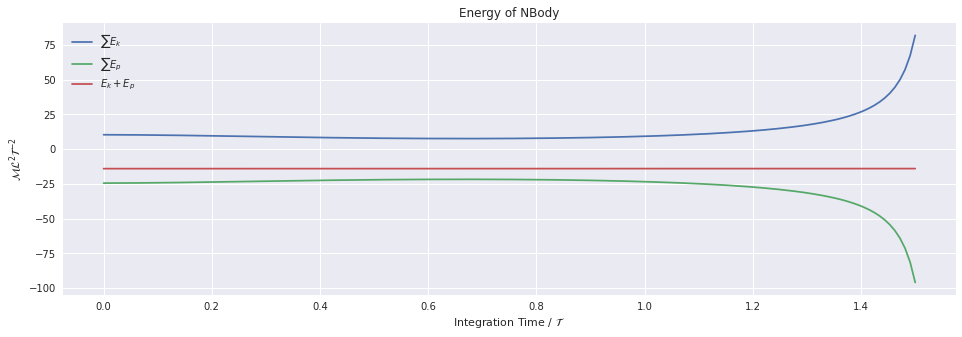

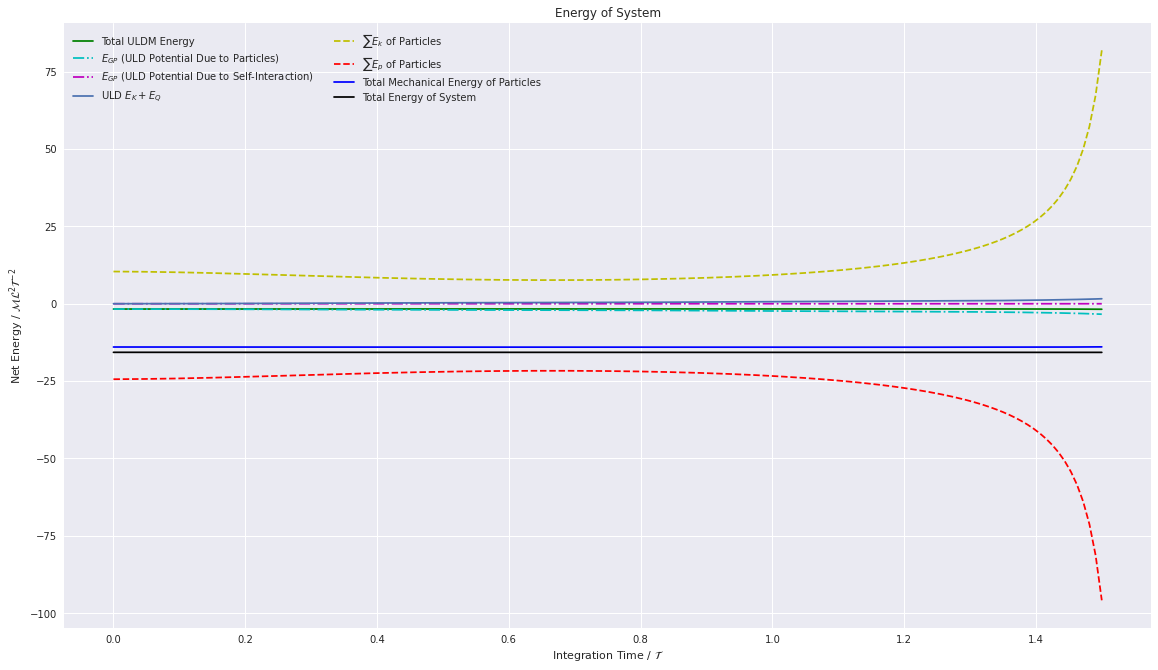

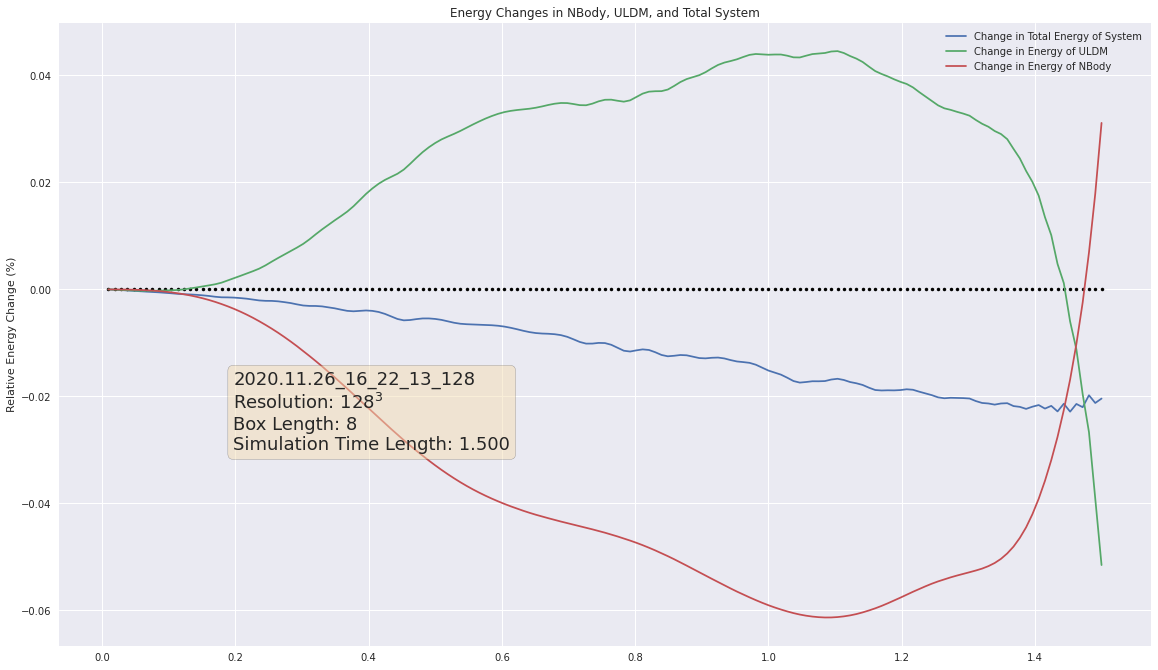

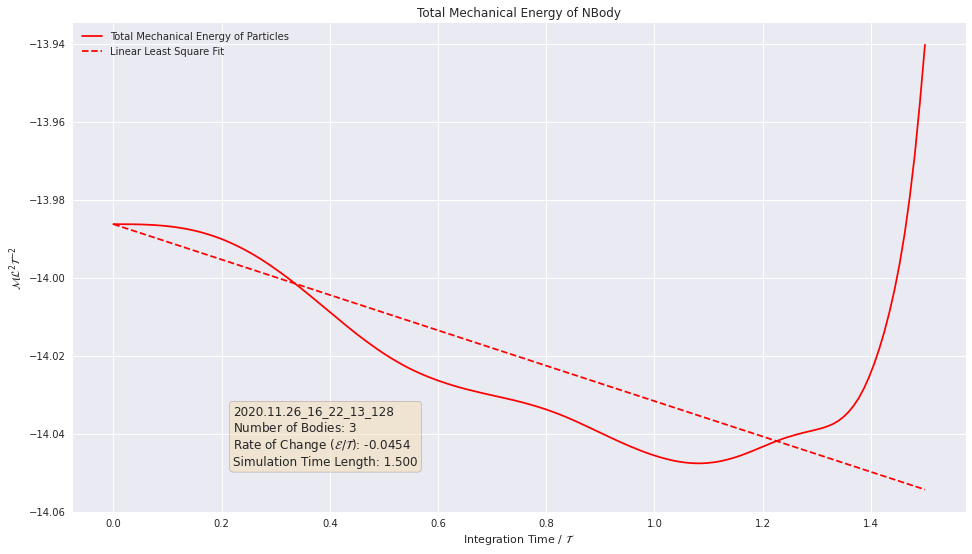

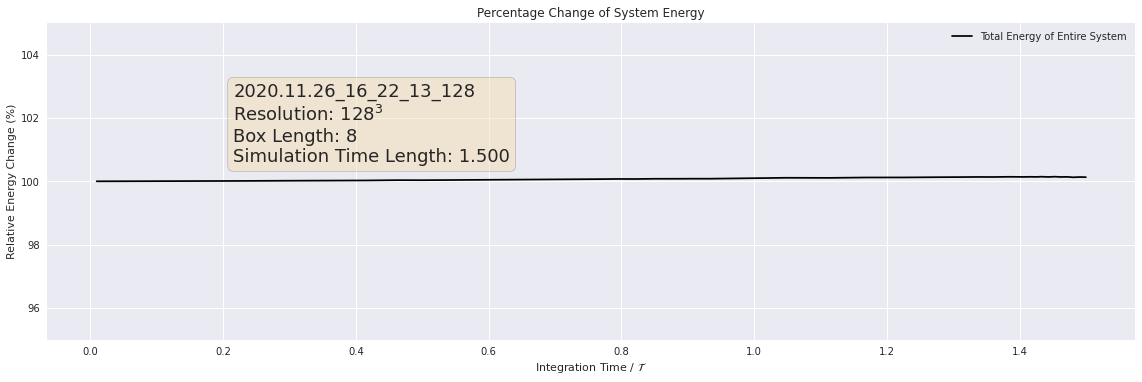

In [31]:
Snap = False

loc = save_path + '/' + TimeStamp

plt.clf()

# Reconstruct List of Masses

ML = []
for i in range(len(particles)):
    particle = particles[i]
    
    mass = PyUL.convert(particle[0],m_mass_unit,'m')
    ML.append(mass)

    print(ML)

# Translating Snapshots back to Time
timerange = np.linspace(0,duration,save_number+1)

NBo = len(particles)

KS = np.zeros(int(EndNum))
PS = np.zeros(int(EndNum))

print(len(particles))
for i in range(int(EndNum)):
    
    Data = TMdata[i]
    
        
    if len(particles)>=2:
        
        
        
        for Mass1 in range(NBo):
            
            Index1 = int(Mass1*6)
            Position1 = Data[Index1:Index1+2]
            m1 = ML[Mass1]
            
            for Mass2 in range (Mass1+1,NBo,1):
                Index2 = int(Mass2*6)
                Position2 = Data[Index2:Index2+2]
                m2 = ML[Mass2]
                
                r = Position1 - Position2

                rN = np.linalg.norm(r)
                
                PS[i] = PS[i] - 1*m1*m2*a/(a*rN+np.exp(-1*a*rN))
            
        
   
    for particleID in range(NBo):
        Vx = Data[int(6*particleID+3)]
        Vy = Data[int(6*particleID+4)]
        Vz = Data[int(6*particleID+5)]
        
        KS[i] = KS[i] + 1/2*ML[particleID]*(Vx**2+Vy**2+Vz**2) 

Tp = np.linspace(0,EndNum-1,EndNum)
Tp = Tp * duration / save_number


plt.figure(figsize = (16,5))
plt.plot(Tp,KS,label = '$\sum E_k$')
#plt.ylim(0,)
if len(particles) >= 2:
    plt.plot(Tp,PS,label = '$\sum E_p$')
    plt.plot(Tp,PS+KS,'-', label = '$E_k + E_p$')
#plt.plot(Tp,0*Tp,'k--')

plt.title('Energy of NBody')
plt.xlabel('Integration Time / $\mathcal{T}$')
plt.ylabel('$\mathcal{M}\mathcal{L}^2\mathcal{T}^{-2}$')

plt.legend()

plt.show()

EnergyName = '{}{}{}{}{}'.format("./",save_path,"/Energy_Total_",TimeStamp,'.jpg')

fig = plt.figure(figsize=(16, 9))


egylist = np.load('{}{}'.format(loc, '/egylist.npy'),allow_pickle=True)
egpcmlist = np.load('{}{}'.format(loc, '/egpcmlist.npy'),allow_pickle=True)
egpsilist = np.load('{}{}'.format(loc, '/egpsilist.npy'),allow_pickle=True)
ekandqlist = np.load('{}{}'.format(loc, '/ekandqlist.npy'),allow_pickle=True)
mtotlist = np.load('{}{}'.format(loc, '/masseslist.npy'),allow_pickle=True)

plt.plot(Tp,egylist,'g-',label='Total ULDM Energy')
plt.plot(Tp,egpcmlist,'c-.',label='$E_{GP}$ (ULD Potential Due to Particles)')
plt.plot(Tp,egpsilist,'m-.',label='$E_{GP}$ (ULD Potential Due to Self-Interaction)')
plt.plot(Tp,ekandqlist,label='ULD $E_{K}+E_{Q}$')


plt.plot(Tp,KS,'y--',label = '$\sum E_k$ of Particles')

if len(particles) >= 2:
    plt.plot(Tp,PS,'r--',label = '$\sum E_p$ of Particles')
    plt.plot(Tp,PS+KS,'b-', label = 'Total Mechanical Energy of Particles')


plt.plot(Tp,PS+KS+egylist,'k-', label = 'Total Energy of System')

plt.legend(ncol=2)

plt.xlabel('Integration Time / $\mathcal{T}$')
plt.ylabel('Net Energy / $\mathcal{M}\mathcal{L}^2\mathcal{T}^{-2}$')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.title('Energy of System')
plt.savefig(EnergyName, format='jpg', dpi=72)

# plt.xlim([90,100])
plt.show()


#==================================================================================================
# The Advanced Energy Change Diagram

Tpt = np.linspace(1,EndNum,EndNum-2,endpoint = False) 

Tpt = Tpt/save_number * duration

KSD = KS - KS[1]

PSD = PS - PS[1]

egylistD = egylist - egylist[1]

TotalED = PSD+KSD+egylistD

fig = plt.figure(figsize=(16, 9))

EnergyDName = '{}{}{}{}{}'.format("./",save_path,"/Energy_Delta_",TimeStamp,'.jpg')

#if len(particles)==2:
#    SystemER = (KS + PS ) / (KS[1]+PS[1])
#    plt.plot(Tpt,SystemER[1:-1],'b-', label = 'Total Energy of Black Holes')

plt.plot(Tpt,TotalED[1:-1],'-', label = 'Change in Total Energy of System')
plt.plot(Tpt,0*Tpt,'k.', label = '')
plt.plot(Tpt,egylistD[1:-1],'-', label = 'Change in Energy of ULDM')
plt.plot(Tpt,KSD[1:-1]+PSD[1:-1],'-', label = 'Change in Energy of NBody')

plt.legend()

textstr = '\n'.join((
    TimeStamp,
    r'Resolution: $%.0f^3$' % (resol, ),
    r'Box Length: %.0f' % (length, ),
    r'Simulation Time Length: %.3f' % (duration, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
plt.text(0, 0, textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='bottom', bbox=props)

plt.ylabel('Relative Energy Change (%)')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

# plt.ylim([98,102])
plt.title('Energy Changes in NBody, ULDM, and Total System')
plt.savefig(EnergyDName, format='jpg', dpi=72)

plt.show()




#==================================================================================================
## Total Mechanical Energy Plot

MES = PS + KS

MESD = PSD + KSD

MESGrad = np.sum(MESD)/np.sum(Tp)

plt.figure(figsize = (16,9))

plt.plot(Tp,MES,'r-', label = 'Total Mechanical Energy of Particles')

plt.plot(Tp,Tp*MESGrad+MES[0],'r--', label = 'Linear Least Square Fit')

textstrN = '\n'.join((
    TimeStamp,
    r'Number of Bodies: $%.0f$' % (NBo, ),
    r'Rate of Change ($\mathcal{E}/\mathcal{T}$): %.4f' % (MESGrad, ),
    r'Simulation Time Length: %.3f' % (duration, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
plt.text(-0, -0.1, textstrN, transform=ax.transAxes, fontsize=12,
        verticalalignment='bottom', bbox=props)

plt.xlabel('Integration Time / $\mathcal{T}$')
plt.ylabel('$\mathcal{M}\mathcal{L}^2\mathcal{T}^{-2}$')

EnergyMName = '{}{}{}{}{}'.format("./",save_path,"/Energy_Mech_",TimeStamp,'.jpg')

plt.legend()
plt.title('Total Mechanical Energy of NBody')
plt.savefig(EnergyMName, format='jpg', dpi=72)

plt.show()



#==================================================================================================

Tpt = np.linspace(1,EndNum,EndNum-2,endpoint = False) 

Tpt = Tpt/save_number * duration

KSD = KS - KS[1]

PSD = PS - PS[1]

egylistD = egylist - egylist[1]

TotalED = PSD+KSD+egylistD


# The Advanced Energy Change Ratio Diagram

fig = plt.figure(figsize=(16, 5))

EnergyD2Name = '{}{}{}{}{}'.format("./",save_path,"/Energy_Pct_",TimeStamp,'.jpg')


TotalER = (KS + PS + egylist) / (KS[1]+PS[1]+egylist[1])*100

ULDER =  egylist/ egylist[1]

#if len(particles)==2:
#    SystemER = (KS + PS ) / (KS[1]+PS[1])
#    plt.plot(Tpt,SystemER[1:-1],'b-', label = 'Total Energy of Black Holes')

if Snap:
    plt.plot(TotalER[1:-1],'k-', label = 'Total Energy of Entire System')
    plt.xlabel('Sample Number')
    
else:
    plt.plot(Tpt,TotalER[1:-1],'k-', label = 'Total Energy of Entire System')
    plt.xlabel('Integration Time / $\mathcal{T}$')

#plt.plot(Tpt,ULDER[1:-1],'g-', label = 'Total Energy of ULDM within Simulation Grid')

plt.legend()

textstr = '\n'.join((
    TimeStamp,
    r'Resolution: $%.0f^3$' % (resol, ),
    r'Box Length: %.0f' % (length, ),
    r'Simulation Time Length: %.3f' % (duration, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
plt.text(0, 0, textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='bottom', bbox=props)

plt.ylabel('Relative Energy Change (%)')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

plt.ylim([95,105])
plt.title('Percentage Change of System Energy')

plt.savefig(EnergyD2Name, format='jpg', dpi=72)

plt.show()


# Summary Animation

In [ ]:
MovieX = 20 # Inches. Rendered at 72 ppi
MovieY = 20
FPS = 30
SkipFrames = 1 # Animate Every x.th Frame.
LogDensity = False
SaveToFile = True

PyULH.AnimSummary(TimeStamp,save_path,MovieX,MovieY,FPS,LogDensity,SkipFrames,SaveToFile)

Helper Build 5. 25 Nov 2020
PyULH Warning: This version is not compatible with PyULH Version 4 or earlier.
Helper Build 5. 25 Nov 2020
PyULH Warning: This version is not compatible with PyULH Version 4 or earlier.
ULHelper: Loaded Planar Mass Density Data 

ULHelper: Loaded Test Mass State Data 

ULHelper: Loaded Planar Gravitational Field Data 

ULHelper: Loaded Test Mass Gradient Data 

ULHelper: Loaded Planar ULD Phase Data 

ULHelper: Loaded 161 Data Entries
[5]
[5, 4]
[5, 4, 3]
Saving  ./ULDScience/AnimSummary_2020.11.26_16_22_13_128.mp4


# Additional Individual Plots

### Field Argument Plotter

This data has not been baked into PyUL Helper, and manual loading is necessary.

In [ ]:
try:
    VTimeStamp = TimeStamp
except NameError:
    VTimeStamp = str('Debug')

AnimName = '{}{}{}{}'.format(save_path,"/AnimPhase_",VTimeStamp,'.mp4')

print("Saving ",AnimName)

plot_axis = 'z' #axis that is set to zero
plt.ioff()
fig0, ax0 = plt.subplots(figsize=(16, 16), dpi=72)
ax0.set_aspect('equal')

PlotRange = np.linspace(-LengthFS/2, LengthFS/2,resol,endpoint = False)

# print(PlotRange)

FPS = 10


def animate3(i):
    ax0.cla()

    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([])
    
    
    Plane = np.real(phasedata[i])
    
    ax0.imshow(Plane,cmap = 'twilight',origin = 'lower',
               vmin = -np.pi, vmax = np.pi,
               extent = (-LengthFS/2,LengthFS/2-LengthFS/resol,-LengthFS/2,LengthFS/2-LengthFS/resol),
              interpolation = 'none')
    
    TMStateLoc = TMdata[i]
    
    for particleID in range(len(particles)):
        
        Color = Colors[np.mod(particleID,5)] # 0, 0.5
        
        TMx = TMStateLoc[int(6*particleID)]
        TMy = TMStateLoc[int(6*particleID+1)]
        TMz = TMStateLoc[int(6*particleID+2)]
        
        Vx = TMStateLoc[int(6*particleID+3)]
        Vy = TMStateLoc[int(6*particleID+4)]
        Vz = TMStateLoc[int(6*particleID+5)]
        ax0.plot([TMy],[TMx],'o',color=(Color[0],Color[1],Color[2],1))
        ax0.quiver([TMy],[TMx],[Vy],[Vx])
  
    if i%FPS == 0 and i!= 0:
        print('Animated %.0f seconds out of %.2f seconds of data.' % (i/FPS, EndNum/FPS))
    
    if i == EndNum-1:
        print('Animation Complete')

interval = 0.15 #in seconds
ani3 = matplotlib.animation.FuncAnimation(fig0,animate3,EndNum,interval=interval*1e+3,blit=False)

'''

Writer = matplotlib.animation.writers['ffmpeg']

writer = Writer(fps=FPS, metadata=dict(artist='PyUltraLightF'))

ani3.save(AnimName, writer=writer)

'''

from IPython.display import HTML
animated_plot3 = HTML(ani3.to_jshtml())

fig0.clear()
display(animated_plot3) 



## [Animation] 2D Mass Density

In [ ]:
Loga = True

try:
    VTimeStamp = TimeStamp
except NameError:
    VTimeStamp = str('Debug')

AnimName = '{}{}{}{}'.format(save_path,"/Anim2D_",VTimeStamp,'.mp4')

print("Saving ",AnimName)

plot_axis = 'z' #axis that is set to zero
plt.ioff()
fig0, ax0 = plt.subplots(figsize=(16, 16), dpi=72)
ax0.set_aspect('equal')


if Loga:
    
    if Uniform:
        data0 = np.log(np.array(data)/Density)
        print("Initial Field is Uniform. Evaluating Change Ratio.")
        planemax = np.max(data0)
        planemin = np.min(data0)
    
    else:
        data0 = np.log(data)
        planemax = np.max(data0)
        planemin = -6
    
    print("Using Log Plot, the Contour Level Limits Are")
    print(planemax,planemin)
    
else:
    data0 = (data)
    planemax = np.max(data0)
    planemin = np.min(data0)
        
levels = np.linspace(planemin, planemax, int(resol/2))

PlotRange = np.linspace(-LengthFS/2, LengthFS/2,resol,endpoint = False)

# print(PlotRange)

FPS = 10


def animate0(i):
    ax0.cla()
    ax0.set_aspect('equal')
    ax0.set_xlim([-LengthFS/2,LengthFS/2])
    ax0.set_ylim([-LengthFS/2,LengthFS/2])
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([])
    
    #ax0.contour(PlotRange,PlotRange,data0[i], levels=levels,cmap = Palette)
    
    
    ax0.imshow(data0[i],cmap = Palette,origin = 'lower',
              vmin = planemin, vmax = planemax,
               extent = (-LengthFS/2,LengthFS/2-LengthFS/resol,-LengthFS/2,LengthFS/2-LengthFS/resol),
              interpolation = 'none')
    
    #ax0.imshow(data[i])

    TMStateLoc = TMdata[i]
    
    for particleID in range(len(particles)):
        
        Color = Colors[np.mod(particleID,5)] # 0, 0.5
        
        TMx = TMStateLoc[int(6*particleID)]
        TMy = TMStateLoc[int(6*particleID+1)]
        TMz = TMStateLoc[int(6*particleID+2)]
        
        Vx = TMStateLoc[int(6*particleID+3)]
        Vy = TMStateLoc[int(6*particleID+4)]
        Vz = TMStateLoc[int(6*particleID+5)]
        ax0.plot([TMy],[TMx],'o',color=(Color[0],Color[1],Color[2],1))
        ax0.quiver([TMy],[TMx],[Vy],[Vx])
        
    fig0.suptitle('{}{}{}'.format('Mass Density - plane ', plot_axis, '=0'), fontsize = 15)
    ax0.text(0.90, 1.1, '{}{}'.format('Snapshot # ', i), horizontalalignment='center', verticalalignment='center', transform=ax0.transAxes)
    
    if i%FPS == 0 and i!= 0:
        print('Animated %.0f seconds out of %.2f seconds of data.' % (i/FPS, EndNum/FPS))
    
    if i == EndNum-1:
        print('Animation Complete')

interval = 0.15 #in seconds
ani0 = matplotlib.animation.FuncAnimation(fig0,animate0,EndNum,interval=interval*1e+3,blit=False)


Writer = matplotlib.animation.writers['ffmpeg']

writer = Writer(fps=FPS, metadata=dict(artist='PyUltraLightF'))


ani0.save(AnimName, writer=writer)

'''

from IPython.display import HTML
animated_plot0 = HTML(ani0.to_jshtml())

fig0.clear()
display(animated_plot0) 
'''

## [Animation] Gravitational Field Slice

In [ ]:
NumSol = len(solitons)
try:
    VTimeStamp = TimeStamp
except NameError:
    VTimeStamp = str('Debug')

AnimName = '{}{}{}{}'.format(save_path,"/Anim3D_",VTimeStamp,'.mp4')

print("Saving ",AnimName)

# Initialization
fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')

ax.view_init(90, 0)

PlotRange = np.linspace(-length/2, length/2,resol)

zoom = 0.8

FPS = 15 

x3D, y3D = np.meshgrid(PlotRange,PlotRange)

phidataP = np.array(phidata)*-1

planemax = np.max(phidataP)*1.2
planemin = np.min(phidataP)

print(planemin,planemax)

levels = np.linspace(planemin, planemax, 100)

def animate(i):
    fig.clear()
    global FPS
    
    TMStateLoc = TMdata[i]
    ax = fig.gca(projection='3d')

    ax.view_init(0, 45)

    ax.set_zlim3d(planemin, planemax)
    ax.set_ylim3d(-length/(2*zoom), length/(2*zoom))                    
    ax.set_xlim3d(-length/(2*zoom), length/(2*zoom))

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    if NumSol != 0:
        
        #ax.contour(PlotRange,PlotRange,(phidata[i]),zdir='z', offset=0, cmap=cm.coolwarm, levels = levels)
        

        zs = phidataP[i].flatten()
        ax.plot_wireframe(x3D,y3D,phidataP[i],rcount = resol, ccount = resol)
 
    
    for particleID in range(len(particles)):
        TMx = TMStateLoc[int(6*particleID)]
        TMy = TMStateLoc[int(6*particleID+1)]
        TMz = TMStateLoc[int(6*particleID+2)]
        
        Vx = TMStateLoc[int(6*particleID+3)]
        Vy = TMStateLoc[int(6*particleID+4)]
        Vz = TMStateLoc[int(6*particleID+5)]
        ax.plot([TMy],[TMx],[TMz],'ko')
        ax.quiver([TMy],[TMx],[TMz],[Vy],[Vx],[Vz],length=length/(resol*zoom), normalize=False)
    #ax.plot([TMS[i,0]],[TMS[i,1]],[TMS[i,2]],'ro')
    
        ax.text(TMy, TMx, TMz, '{}{}{}'.format(particleID,'Particle Snapshot # ', i))

    
    if i%FPS == 0 and i!= 0:
        print('Animated %.0f seconds out of %.2f seconds of data.' % (i/FPS, EndNum/FPS))
        
    if i == EndNum-1:
        print('Animation Complete')
        
    plt.draw() 

Writer = matplotlib.animation.writers['ffmpeg']

writer = Writer(fps=FPS, metadata=dict(artist='PyUltraLightF'))

interval = 0.05 #in seconds


ani = matplotlib.animation.FuncAnimation(fig,animate,EndNum,interval=interval*1e+3,blit=False)

ani.save(AnimName, writer=writer)
 

In [ ]:
Loga = False

data0 = phidataP
try:
    VTimeStamp = TimeStamp
except NameError:
    VTimeStamp = str('Debug')

AnimName = '{}{}{}{}'.format(save_path,"/Anim3D_",VTimeStamp,'.mp4')

print("Saving ",AnimName)

plot_axis = 'z' #axis that is set to zero
plt.ioff()
fig0, ax0 = plt.subplots(figsize=(16, 16), dpi=72)
ax0.set_aspect('equal')


data0 = (data)
planemax = np.max(data0)
planemin = np.min(data0)
        
levels = np.linspace(planemin, planemax, int(resol/2))

PlotRange = np.linspace(-LengthFS/2, LengthFS/2,resol,endpoint = False)

# print(PlotRange)

FPS = 10


def animate0(i):
    ax0.cla()
    ax0.set_aspect('equal')
    ax0.set_xlim([-LengthFS/2,LengthFS/2])
    ax0.set_ylim([-LengthFS/2,LengthFS/2])
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([])
    
    #ax0.contour(PlotRange,PlotRange,data0[i], levels=levels,cmap = Palette)
    
    
    ax0.imshow(data0[i],cmap = Palette,origin = 'lower',
              vmin = planemin, vmax = planemax,
               extent = (-LengthFS/2,LengthFS/2-LengthFS/resol,-LengthFS/2,LengthFS/2-LengthFS/resol),
              interpolation = 'none')
    
    #ax0.imshow(data[i])

    TMStateLoc = TMdata[i]
    
    for particleID in range(len(particles)):
        
        Color = Colors[np.mod(particleID,5)] # 0, 0.5
        
        TMx = TMStateLoc[int(6*particleID)]
        TMy = TMStateLoc[int(6*particleID+1)]
        TMz = TMStateLoc[int(6*particleID+2)]
        
        Vx = TMStateLoc[int(6*particleID+3)]
        Vy = TMStateLoc[int(6*particleID+4)]
        Vz = TMStateLoc[int(6*particleID+5)]
        ax0.plot([TMy],[TMx],'o',color=(Color[0],Color[1],Color[2],1))
        ax0.quiver([TMy],[TMx],[Vy],[Vx])
        
    fig0.suptitle('{}{}{}'.format('Mass Density - plane ', plot_axis, '=0'), fontsize = 15)
    ax0.text(0.90, 1.1, '{}{}'.format('Snapshot # ', i), horizontalalignment='center', verticalalignment='center', transform=ax0.transAxes)
    
    if i%FPS == 0 and i!= 0:
        print('Animated %.0f seconds out of %.2f seconds of data.' % (i/FPS, EndNum/FPS))
    
    if i == EndNum-1:
        print('Animation Complete')

interval = 0.15 #in seconds
ani0 = matplotlib.animation.FuncAnimation(fig0,animate0,EndNum,interval=interval*1e+3,blit=False)


Writer = matplotlib.animation.writers['ffmpeg']

writer = Writer(fps=FPS, metadata=dict(artist='PyUltraLightF'))


ani0.save(AnimName, writer=writer)

'''

from IPython.display import HTML
animated_plot0 = HTML(ani0.to_jshtml())

fig0.clear()
display(animated_plot0) 
'''

# Acceleration of Particles

In [ ]:
pID = 0 # 0,1,2,...

plt.clf()
plt.figure(figsize=(16, 9))

graddataP = (graddata)
for i in range(EndNum):
    pID = pID*3
    plt.plot(i,graddataP[i][0],'r.',label = '$x$')
    plt.plot(i,graddataP[i][1],'g.',label = '$y$')
    plt.plot(i,graddataP[i][2],'b.',label = '$z$')

plt.xlabel('Snapshot Number')
plt.ylabel('Particle Acceleration')
plt.legend()
plt.show()

## Rate Estimate of Energy Change

In [ ]:
timerange = np.linspace(0,duration,save_number+1)

TotalED = PSD+KSD+egylistD

EDFit = np.polyfit(timerange,TotalED,1)

print(EDFit)

MaxED = max(TotalED.min(), TotalED.max(), key=abs)

FinalED = TotalED[-1]

print(FinalED, MaxED)

plt.figure(figsize = (16,9))

plt.plot(timerange,TotalED,'k-')

plt.plot(timerange,EDFit[0]*timerange+EDFit[1],'r--')

plt.show()

## [Bonus Interactive]: 3D Field Visualization

Loads all data into RAM. Very slow.

In [ ]:
if save_rho:
    
    with open('{}{}'.format(save_path, '/timestamp.txt'), 'r') as timestamp:
        ts = timestamp.read()
        print('PyUL NBody: Loading Folder',ts)

    loc = save_path + '/' + ts

    import time   
    import warnings 
    warnings.filterwarnings("ignore")
    plt.ioff()

    EndNum = 0
    Rhodata = []
    TMdata = []

    for x in np.arange(0,save_number+1,1):
    #for x in np.arange(0,550,1):    

        try:

            Rhodata.append(np.load('{}{}{}{}'.format(loc, '/rho_#', x, '.npy')))
            TMdata.append(np.load('{}{}{}{}'.format(loc, '/TM_#', x, '.npy')))
            EndNum += 1
        except FileNotFoundError:

            TimeStamp = ts
            print("PyUL NBody: Run incomplete or the storage is corrupt!")

            break

    print("PyUL NBody: Loaded", EndNum, "Data Entries. Which one to plot?")
    
    PlotNum = int(input())

    import plotly.graph_objects as go
    
    import plotly.io as pio
    
    import numpy as np
    
    if Uniform:
        Rhodata = np.log(np.array(Rhodata))
        
    

    HL = length/2
    XP, YP, ZP = np.mgrid[-HL:HL:resol/4*1j, -HL:HL:resol/4*1j, -HL:HL:resol/4*1j]

    print(len(XP))
    values = Rhodata[PlotNum]
    
    values = values.flatten()
    
    shrink = int(resol/4)**3
    
    Values = np.zeros(shrink)
    
    for ii in range(shrink):
        Values[ii] = values[int(ii*4)]

    fig3D = go.Figure(data=go.Volume(
        x=XP.flatten(),
        y=YP.flatten(),
        z=ZP.flatten(),
        value=Values,
        isomin=np.min(Rhodata),
        isomax=np.max(Rhodata),
        opacity=0.02, # needs to be small to see through all surfaces
        surface_count=int(resol/4), # needs to be a large number for good volume rendering
        ))

else:
    raise RuntimeError("You did not save field data!")

In [ ]:
import plotly.io as pio
pio.write_html(fig3D, 'Trial.html')

## [Bonus Interactive]: 3D Density Visualization

In [ ]:
print(phidataP[1])

In [ ]:
import plotly.graph_objects as go
 
import plotly.io as pio
import numpy as np

import pandas as pd

phidataPL = pd.DataFrame(data=phidataP[287], index=None, columns=None)

fig = go.Figure(data=[go.Surface(z=phidataPL.values)])

#fig.update_layout(title='$z=0$', autosize=False,width=500, height=500,margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [ ]:
pio.write_html(fig, 'Soliton512.html')

In [ ]:
print(phidataPL)

In [ ]:
z_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')

fig = go.Figure(data=[go.Surface(z=z_data.values)])

fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [ ]:
print(z_data)